In [140]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

# Using pandas to clean the natural gas data

In [141]:
# import raw gas usage data from csv
file_path = 'raw_data/10yr_gas_data.csv'
df = pd.read_csv(file_path)

In [142]:
# removing individual date columns and adding a new date column that includes all 10 years
dates = []
states = []
values = []

# loop through columns of columns (DC is included so there are 51 state columns)
for i in range(1,52):

   #loop through rows
    for j in range(0,132): 
        date = df.iloc[j,0] # gets date from first column
        dates.append(date)  # adds date to dates list

        state_str = df.columns[i] # gets column title
        state_str = state_str.split(' Natural', 1) #splits the title at the first occurence of the word 'natural'
        state = state_str[0] # saves the state name 
        states.append(state) # adds the state to the states list

        value = df.iloc[j,i] # retrieves the value from the current row,value pair
        values.append(value) # adds the value to the values list 
       


In [143]:
# create data frame to store gas data
df_clean = pd.DataFrame({
    'Date': dates,
    'State': states,
    'Natural Gas Consumption (MMcf)':values
})

df_clean

,Date,State,Natural Gas Consumption (MMcf)
0,Jan-2010,Alabama,9202.647
1,Feb-2010,Alabama,7762.261
2,Mar-2010,Alabama,6612.051
3,Apr-2010,Alabama,2987.217
4,May-2010,Alabama,1142.784
...,...,...,...
6727,Aug-2020,Wyoming,199.347
6728,Sep-2020,Wyoming,289.642
6729,Oct-2020,Wyoming,567.622
6730,Nov-2020,Wyoming,1532.600


In [144]:
# output clean gas data to csv
output_path = 'clean_data/natural_gas_data.csv'
df_clean.to_csv(output_path)

# Using pandas to clean temperature data

In [145]:
# read in temp data from csv into dataframe
file_path = 'all_states_ave_temp.csv'
df2 = pd.read_csv(file_path)


In [146]:
# show temp data frame
df2.head()

,Alabama,Unnamed: 1,Average Temperature,Unnamed: 3
0,Units: Degrees Fahrenheit,NaN,NaN,NaN
1,Base Period: 2010-2020,NaN,NaN,NaN
2,Missing: -99,NaN,NaN,NaN
3,Date,NaN,Value,Anomaly
4,200001,Alabama,46.5,1.6


In [147]:
# drop NaN values from the temp dataframe
df2.dropna(how='any', inplace=True)

In [148]:
# list of columns to rename
column_names = {
    'Unnamed: 1': 'State', 
    'Average Temperature': 'Avg Temp (F)',
    'Unnamed: 3': 'Anomaly',
    'Alabama' : 'Date'
    }
# renaming columns
df2.rename(columns=column_names, inplace=True)
#reseting index
df2.reset_index(drop=True, inplace=True)
# showing results
df2.head()

,Date,State,Average Temperature,Anomaly
0,200001,Alabama,46.5,1.6
1,200002,Alabama,52.3,2.5
2,200003,Alabama,58.9,2.7
3,200004,Alabama,60.1,-3.8
4,200005,Alabama,74,2.4


In [149]:
# output the clean temp data to csv file
output_path = 'clean_data/avg_temp_by_state.csv'
df2.to_csv(output_path)

# Filtering and merging data frames using pandas

In [170]:
# file paths
gas_file = 'clean_data/natural_gas_data.csv'
weather_file = 'clean_data/avg_temp_by_state.csv'

# import the files 
weather_df = pd.read_csv(weather_file)
gas_df = pd.read_csv(gas_file)

In [171]:
# droping the extra column that gets added
gas_df.drop(columns='Unnamed: 0', inplace=True)
weather_df.drop(columns='Unnamed: 0', inplace=True)


In [172]:
# drop dates before 2010 and after 2019 from weather data
weather_df.drop(weather_df.loc[weather_df['Date'] < 201000].index, inplace=True)
weather_df.drop(weather_df.loc[weather_df['Date'] >= 202000].index, inplace=True)

In [173]:
# drop 2020 (since its not in the weather data) as well as DC (for the same reason)
# hawaii also had to be dropped from gas, as the data was not available via noaa
gas_df.drop(gas_df.loc[gas_df['Date'].str.contains("2020")].index, inplace=True)
gas_df.drop(gas_df.loc[gas_df['State']=='District of Columbia'].index, inplace=True)
gas_df.drop(gas_df.loc[gas_df['State']=='Hawaii'].index, inplace=True)
len(gas_df)

5880

In [175]:
# format the date variables to be uniform for merging - WEATHER
weather_df['Date'] = pd.to_datetime(weather_df['Date'], format='%Y%m')
weather_df['Date'] = weather_df['Date'].apply(lambda x: x.strftime('%Y-%m'))

In [179]:
# format the date variables to be uniform for merging - GAS
gas_df['Date'] = pd.to_datetime(gas_df['Date'], format='%b-%Y')
gas_df['Date'] = gas_df['Date'].apply(lambda x: x.strftime('%Y-%m'))

In [314]:
# show df to confirm correct date format
weather_df.head()

,Date,State,Average Temperature,Anomaly
120,2010-01,Alabama,40.0,-4.9
121,2010-02,Alabama,40.6,-9.2
122,2010-03,Alabama,51.2,-5.0
123,2010-04,Alabama,64.2,0.3
124,2010-05,Alabama,73.3,1.7


In [315]:
# show df to confirm correct date format
gas_df.head()

,Date,State,Natural Gas Consumption (MMcf)
0,2010-01,Alabama,9202.647
1,2010-02,Alabama,7762.261
2,2010-03,Alabama,6612.051
3,2010-04,Alabama,2987.217
4,2010-05,Alabama,1142.784


In [181]:
# merge the weather and gas data together into single df and display results
combined_df = pd.merge(gas_df, weather_df, how='outer')
combined_df.head()

,Date,State,Natural Gas Consumption (MMcf),Average Temperature,Anomaly
0,2010-01,Alabama,9202.647,40.0,-4.9
1,2010-02,Alabama,7762.261,40.6,-9.2
2,2010-03,Alabama,6612.051,51.2,-5.0
3,2010-04,Alabama,2987.217,64.2,0.3
4,2010-05,Alabama,1142.784,73.3,1.7
...,...,...,...,...,...
5875,2019-08,Wyoming,212.409,64.9,0.3
5876,2019-09,Wyoming,189.987,56.7,0.1
5877,2019-10,Wyoming,589.805,34.2,-8.9
5878,2019-11,Wyoming,1847.274,30.2,-0.9


# Analysis

In [182]:
# group together by state
state_df = combined_df.groupby('State').mean()

In [183]:
# drop states that use less than 5000 MMcf per year
state_df.drop(state_df.loc[state_df['Natural Gas Consumption (MMcf)'] <= 5000].index, inplace=True)
state_df.head()

,Natural Gas Consumption (MMcf),Average Temperature,Anomaly
State,,,
California,37477.004692,59.520000,-0.013333
Colorado,10648.595550,46.613333,-0.011667
Georgia,10060.952758,64.768333,-0.040000
Illinois,34740.719725,52.895833,-0.045833
Indiana,11300.906708,52.691667,-0.066667


In [184]:
len(state_df)

24

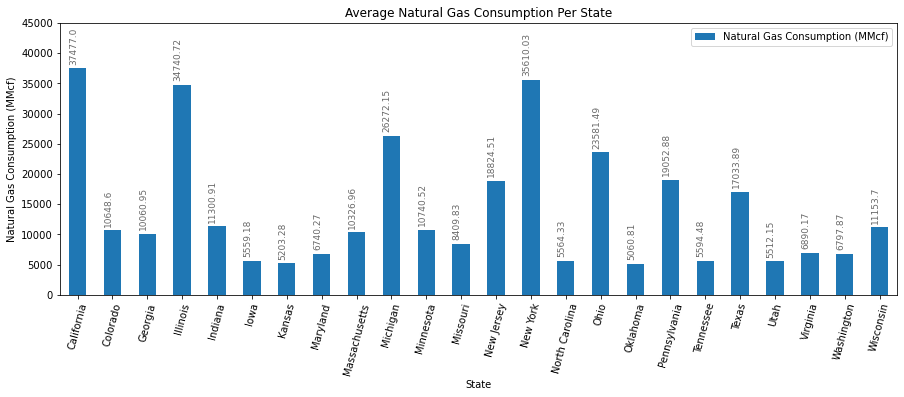

In [185]:
# JMJ noted that this should say Average instead of total so I updated it. 
ax1 = state_df.plot(kind='bar', y='Natural Gas Consumption (MMcf)', rot=75, figsize=(15, 5))
ylabel = ax1.set_ylabel('Natural Gas Consumption (MMcf)')
title = ax1.set_title('Average Natural Gas Consumption Per State')
plt.savefig('output_data/total_gas_usage_per_state.png')
#JMJ extended the limits of the y axis to view the values better
ax1.set_ylim(0,45000)
#JMJ added the indvidual bar labels for the graph using this source: https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
for i in ax1.patches:
    #JMJ added to get the width and height of the x and y bars to match the label to the appropriate space
    ax1.text(i.get_x()+.001, i.get_height()+1000, \
        str(round((i.get_height()),2)), fontsize=9, color='dimgrey',rotation=90)

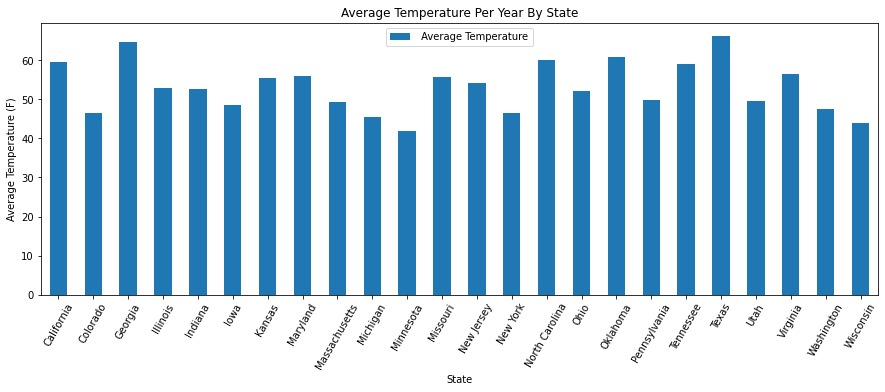

In [186]:
ax1 = state_df.plot(kind='bar', y=' Average Temperature', rot=60, figsize=(15, 5))
ylabel = ax1.set_ylabel('Average Temperature (F)')
title = ax1.set_title('Average Temperature Per Year By State')
plt.savefig('output_data/avg_temp_per_state.png')

In [187]:
cali_data = combined_df.loc[combined_df['State'] == 'California']



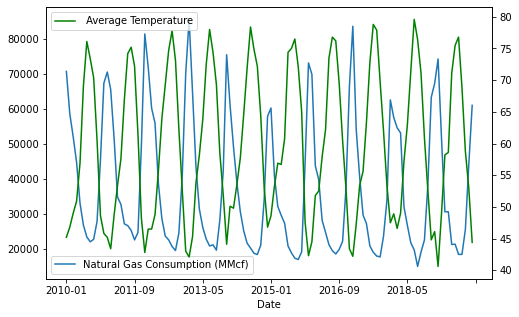

In [188]:
# ax1 = df1.plot()

# ax2 = ax1.twinx()
# ax2.spines['right'].set_position(('axes', 1.0))
# df2.plot(ax=ax2)

ax1 = cali_data.plot(kind='line', x='Date', y='Natural Gas Consumption (MMcf)')
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
cali_data.plot(ax=ax2, x= 'Date', y= ' Average Temperature', color='green', figsize=(8,5))

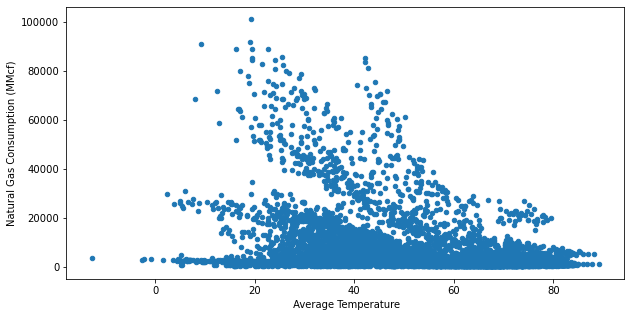

In [189]:
combined_df.plot(kind='scatter', x=' Average Temperature', y='Natural Gas Consumption (MMcf)', figsize=(10, 5))

# Add Population data to data set

In [256]:
# read pop data from csv
pop_file = 'clean_data/10yr_population_data.csv'
pop_df = pd.read_csv(pop_file)

In [257]:
# drop unnamed index colum that is added
pop_df.drop(columns='Unnamed: 0', inplace=True)
pop_df.head()

In [258]:
# loops through and removes '.' from  state string
for i in range(0,len(pop_df)):
    st_string = pop_df.iloc[i, 0]
    st_string = st_string.split(".", 2) 
    pop_df.iloc[i, 0] = st_string[0]

In [259]:
# drop DC from population data to match rest of data
pop_df.drop(pop_df.loc[pop_df['state'] == 'District of Columbia'].index, inplace=True)

In [260]:
# reformat pop data to match the layout of other data (each year was a column, now theres one year column)
states = []
years = []
pops = []

# loop through columns (10 years)
for i in range(1, 11): 
    # loop through rows (49 states)
    for j in range(0, 50):
        state = pop_df.iloc[j,0]
        states.append(state)

        year = pop_df.columns[i]
        years.append(year)

        pop = pop_df.iloc[j, i]
        pops.append(pop)

In [261]:
# create new data frame for reformatted pop data
pop_df = pd.DataFrame({
    'State': states,
    'Year': years,
    'Population': pops
})

pop_df.head()

,State,Year,Population
0,Alabama,2010,"4,785,437"
1,Alaska,2010,"713,910"
2,Arizona,2010,"6,407,172"
3,Arkansas,2010,"2,921,964"
4,California,2010,"37,319,502"


In [262]:
# sort states alphabetically and reset index
pop_df.sort_values(by='State', inplace=True)
pop_df.reset_index(drop=True, inplace=True)

In [263]:
combined_df['Date'] = pd.to_datetime(combined_df['Date'], format='%Y-%m')
pop_df['Date'] = pd.to_datetime(pop_df['Year'], format="%Y")

In [264]:
pop_df.drop(columns='Year', inplace=True)

In [265]:
combined_year_df = combined_df.groupby([combined_df['State'],combined_df['Date'].dt.year])

In [266]:
combined_means = combined_year_df.mean()

combined_means = combined_means.reset_index()

In [268]:
combined_means['Date'] = pd.to_datetime(combined_means['Date'], format='%Y')

In [269]:
combo_years = pd.merge(combined_means, pop_df, how='left', on=['Date', 'State'])

In [270]:
combo_years.dropna(how='any', inplace=True)

In [271]:
combo_years['Date'] = combo_years['Date'].apply(lambda x: x.strftime('%Y'))

In [272]:
combo_years.rename(columns={'Date':'Year'}, inplace=True)

In [273]:
combo_years.reset_index(drop=True, inplace=True)

In [274]:
for i in range(0, len(combo_years)):
   combo_years.iloc[i, 5] = int(combo_years.iloc[i, 5].replace(',',''))

In [275]:
combo_years['Population'] = combo_years['Population'].astype(int)
combo_years.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   State                           490 non-null    object 
 1   Year                            490 non-null    object 
 2   Natural Gas Consumption (MMcf)  490 non-null    float64
 3    Average Temperature            490 non-null    float64
 4   Anomaly                         490 non-null    float64
 5   Population                      490 non-null    int32  
dtypes: float64(3), int32(1), object(2)
memory usage: 21.2+ KB


In [287]:
combo_years.head()

,State,Year,Natural Gas Consumption (MMcf),Average Temperature,Anomaly,Population,Gas Usage Per Person (MMcf)
0,Alabama,2010,3517.939750,62.708333,-1.425000,4785437,0.000735
1,Alabama,2011,3048.491417,63.833333,-0.300000,4799069,0.000635
2,Alabama,2012,2298.298333,64.916667,0.783333,4815588,0.000477
3,Alabama,2013,2921.568667,62.600000,-1.533333,4830081,0.000605
4,Alabama,2014,3250.500833,62.033333,-2.100000,4841799,0.000671


In [302]:

# drop states that use less than 5000 MMcf per year
combo_years = combo_years.loc[combo_years['Natural Gas Consumption (MMcf)'] >= 5000]
combo_years = combo_years.reset_index(drop=True)
len(combo_years['State'].unique())


24

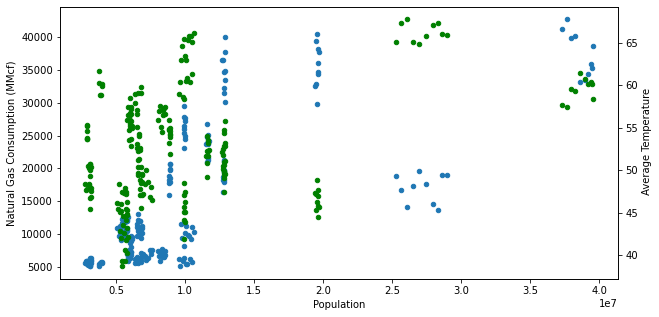

In [303]:
# ax1 = df1.plot()

# ax2 = ax1.twinx()
# ax2.spines['right'].set_position(('axes', 1.0))
# df2.plot(ax=ax2)

ax1 = combo_years.plot(kind='scatter', x='Population', y='Natural Gas Consumption (MMcf)', figsize=(10, 5))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
combo_years.plot(kind='scatter', ax=ax2, x='Population', y=' Average Temperature', color='green')

In [304]:
combo_years['Gas Usage Per Person (MMcf)'] = combo_years['Natural Gas Consumption (MMcf)'] / combo_years['Population']
combo_years['Gas Usage Per Person (MMcf)'] = combo_years['Gas Usage Per Person (MMcf)'].astype(float)

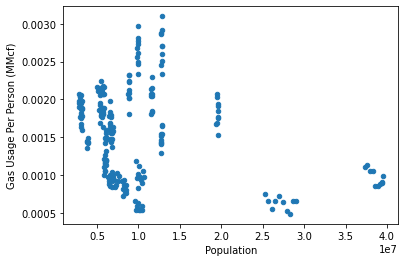

In [305]:
combo_years.plot(kind='scatter', x='Population', y='Gas Usage Per Person (MMcf)')

In [306]:
state_mean = combo_years.groupby('State').mean()

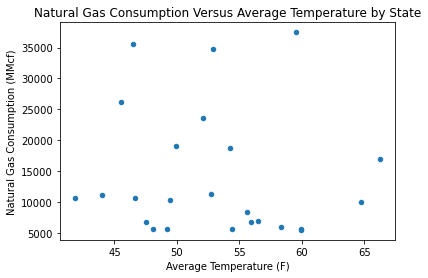

In [307]:
ax1 = state_mean.plot(kind='scatter', x=' Average Temperature', y='Natural Gas Consumption (MMcf)')
xlabel = ax1.set_xlabel('Average Temperature (F)')
title = ax1.set_title('Natural Gas Consumption Versus Average Temperature by State')

In [308]:
# function to plot linear regressions
def plotLinRegress(x, y, xlabel, ylabel, labelpos, title, image_name):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x,y)
    print(f'The r-squared is: {rvalue**2}')
    regress_values = x * slope + intercept
    line_eq = f'y = {round(slope,2)}x + {round(intercept,2)}'
    
    plt.scatter(x,y)
    plt.plot(x, regress_values, "r-")
    plt.annotate(line_eq, labelpos, fontsize=15, color='red')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig(f'output_data/{image_name}.png')

The r-squared is: 0.0071379610127742235


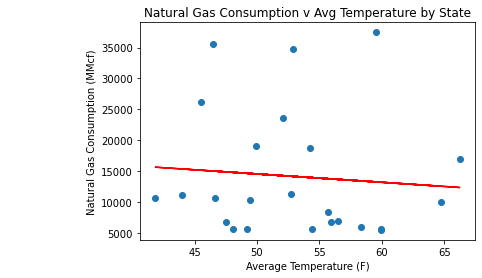

In [309]:
xlabel = 'Average Temperature (F)'
ylabel = 'Natural Gas Consumption (MMcf)'
title = 'Natural Gas Consumption v Avg Temperature by State'
labelpos = (30, 30000)
image_name = 'gas_usage_v_temp_by_state'

plotLinRegress(state_mean[' Average Temperature'], state_mean['Natural Gas Consumption (MMcf)'], xlabel, ylabel, labelpos, title, image_name)

The r-squared is: 0.15178578510370927


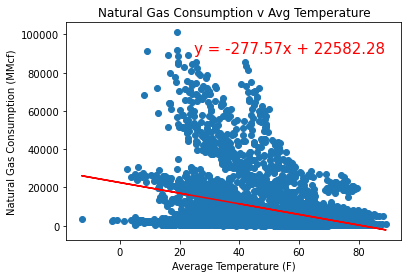

In [310]:
xlabel = 'Average Temperature (F)'
ylabel = 'Natural Gas Consumption (MMcf)'
labelpos = (25,90000)
title = 'Natural Gas Consumption v Avg Temperature'
image_name = 'gas_usage_v_temp_total'

plotLinRegress(combined_df[' Average Temperature'], combined_df['Natural Gas Consumption (MMcf)'], xlabel, ylabel, labelpos,title, image_name)

The r-squared is: 0.5111068269975281


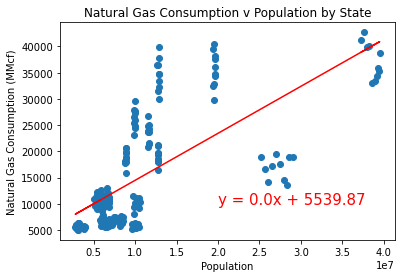

In [311]:
xlabel = 'Population'
ylabel = 'Natural Gas Consumption (MMcf)'
labelpos = (20000000, 10000)
title = 'Natural Gas Consumption v Population by State'
image_name = 'gas_usage_v_pop'

plotLinRegress(combo_years['Population'], combo_years['Natural Gas Consumption (MMcf)'], xlabel, ylabel, labelpos, title, image_name)

The r-squared is: 0.08072897389874313


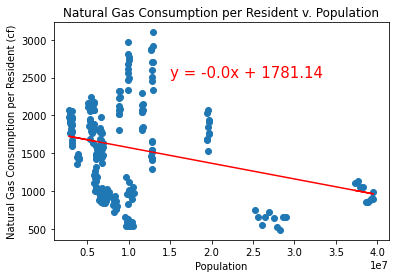

In [312]:
xlabel = 'Population'
ylabel = 'Natural Gas Consumption per Resident (cf)'
labelpos = (15000000, 2500)
title = 'Natural Gas Consumption per Resident v. Population'
image_name = 'gas_usage_per_person'
y = (combo_years['Gas Usage Per Person (MMcf)']) * 1000000 # changes unit from million cubic feet to just cubic feet
plotLinRegress(combo_years['Population'], y , xlabel, ylabel, labelpos, title, image_name)

In [313]:
#JMJ adding Gas Consumption over time using a color for each state
